# (1) Import of needed libraries

In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim import corpora

from gensim.models import TfidfModel
import numpy as np

from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

from gensim.models.ldamodel import LdaModel
from pprint import pprint

from gensim.models import HdpModel

# (2) Import of complaint data

In [2]:
df = pd.read_csv('complaints.csv',dtype = {'ZIP code': str})

pd.set_option('display.max_colwidth', None)

df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-11-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",TX,78541,Servicemember,NaN,Web,2022-11-19,In progress,Yes,NaN,6222374
1,2022-10-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Improper use of your report,Reporting company used your report improperly,"In accordance with the fair credit reporting act XXXX account XXXX XXXX # XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Has violated my rights,15 U.S.C.1681 section 602 A states that I have a right to my privacy. 1 5 U.S.C. 1681 section 602 A section 2 states a consumer reporting company can not furnish an account without my written instructions which I have never given.",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,30043,NaN,Consent provided,Web,2022-10-13,Closed with explanation,Yes,NaN,6079679
2,2022-10-13,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Again, I was going through my records & noticed the fraudulent accounts which do not belong to me STILL reposting on my file in Transunion. The other bureaus have already DELETED this fraudulent information so my question is why do you still report these damaging records? I also contacted XXXX XXXX XXXX and then talked to their staff, and they agreed to remove the accounts from my file. I have already disputed these accounts several times and stated that I am an identity theft victim. I even forwarded my FTC report I filed online on their website along with my personal information and documents but still, you chose to continue reporting these accounts. Credit Bureaus are bound to comply with the FCRA regulation section 605b but you never cared nor paid any attention to my Disputes. You became negligent of the FCRA law and continued reporting this information on my Credit File without Proper Verification or Investigation. Now, I want you to REMOVE these items from my file like the other bureaus have done. \n\nXXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,90660,NaN,Consent provided,Web,2022-10-13,Closed with non-monetary relief,Yes,NaN,6076990
3,2022-10-12,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19148,NaN,Consent not provided,Web,2022-10-12,Closed with non-monetary relief,Yes,NaN,6080312
4,2022-11-19,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Na

# (3) Data Pre-Processing

## (3.1.a) Data Filtering (1/2)

Number of documents: 1164


<Axes: xlabel='Product'>

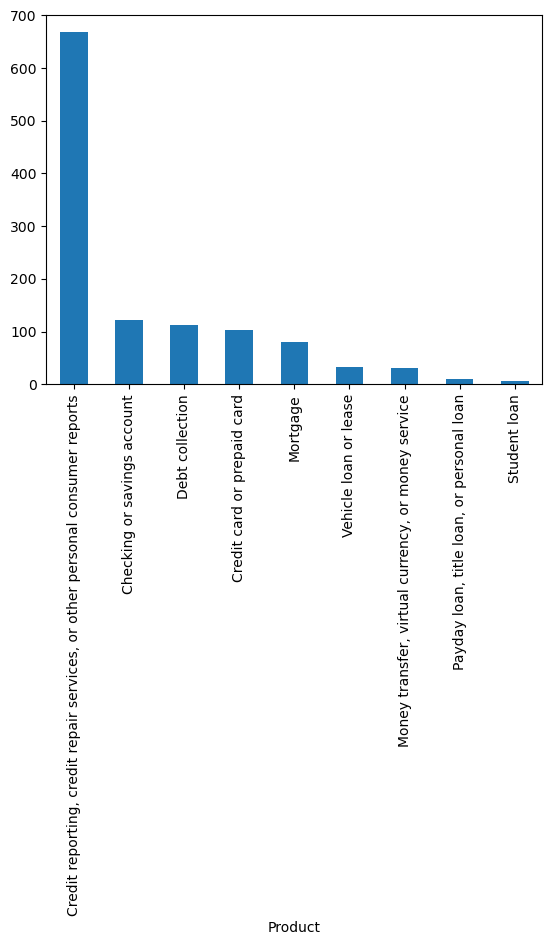

In [3]:
df = df[['Date received', 'Product','Consumer complaint narrative']]
df['Date received']= pd.to_datetime(df['Date received'])

df = df[df['Consumer complaint narrative'].notna()]

df = df[(df['Date received'].dt.year == 2022) & (df['Date received'].dt.month == 11)]

print("Number of documents:", len(df))

df['Product'].value_counts().plot(kind='bar')

## (3.1.b) Data Filtering (2/2)

In [4]:
df = df[(df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports') ]
print("Number of documents:", len(df))

Number of documents: 668


## (3.2) Tokenization including removal of stopwords, capitalization & filtering on alphabetic data

In [5]:
stopwords = stopwords.words('english') + ["xx", "xxxx","im","please","xxxxxxxx"]

def tokenize (column):
    token_data = nltk.word_tokenize(column)
    return [w.lower() for w in token_data if w.lower() not in stopwords and w.isalpha() and len(w)>2]


df['token_data'] = df['Consumer complaint narrative'].apply(lambda x: tokenize(x))

df.head()

,Date received,Product,Consumer complaint narrative,token_data
86,2022-11-07,"Credit reporting, credit repair services, or other personal consumer reports",There were several inaccurate personal information in my credit report. I am having difficulties in getting them removed. It might be caused by fraud or error on credit reporting.,"[several, inaccurate, personal, information, credit, report, difficulties, getting, removed, might, caused, fraud, error, credit, reporting]"
261,2022-11-01,"Credit reporting, credit repair services, or other personal consumer reports","This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Regardless of the multiple written requests, the unverified account listed below is still reporting on my credit report in violation of federal law. Under Section 609 ( a ) ( 1 ) ( A ) Disclosures to consumers [ 15 U.S.C. 1681g ] ( ( a ) Information on file ; sources ; report recipients. Experian shall, upon request, and subject to 610 ( a ) ( 1 ) [ 1681h ], clearly and accurately disclose to the consumer. If the consumer to whom the file relates requests that the first 5 digits of the social security number ( or similar identification number ) of the consumer not be included in the disclosure and the consumer reporting agency has received appropriate proof of the identity of the requester, the consumer reporting agency shall so truncate such number in such disclosure. & Section 611 ( a ) ( 1 ) ( A ) Procedure in case of disputed accuracy [ 15 U.S.C. 1681i ] ( a ) Reinvestigations of Disputed Information. If the completeness or accuracy of any item of information contained in my file at Experian is disputed by the consumer and the consumer notifies the agency directly, or indirectly through a creditor, the Bureaus shall, free of charge, conduct a reasonable reinvestigation to determine whether the disputed information is inaccurate and record the current status of the disputed information or delete the items from my file in accordance with paragraph ( 5 ), before the end of the 30-day period beginning on the date on which the agency receives the notice of the dispute from the consumer or creditor. The account below should be corrected ASAP : XXXX XXXX XXXX XXXXXXXX","[duplicate, complaint, filed, third, party, filing, complaint, see, complaint, processed, letter, law, regardless, multiple, written, requests, unverified, account, listed, still, reporting, credit, report, violation, federal, law, section, disclosures, consumers, information, file, sources, report, recipients, experian, shall, upon, request, subject, clearly, accurately, disclose, consumer, consumer, file, relates, requests, first, digits, social, security, number, similar, identification, number, consumer, included, disclosure, consumer, reporting, agency, received, appropriate, proof, identity, requester, consumer, reporting, agency, shall, truncate, number, disclosure, section, procedure, case, disputed, accuracy, reinvestigations, disputed, information, completeness, accuracy, item, information, contained, file, experian, disputed, consumer, consumer, notifies, agency, directly, indirectly, creditor, bureaus, shall, free, charge, ...]"
265,2022-11-05,"Credit reporting, credit repair services, or other personal consumer reports","My name is XXXX XXXX this complaint is not made in error neither is it being made by a third party.I declare under penalty of perjury I am alleging that a person or company- without my authorization- from unauthorized use of my social security number and card used my personal identifying information to apply for goods, services, or money ; and, was successful in creating some accounts. I have no knowledge of this and All is being investigated by the FTC.","[name, complaint, made, error, neither, made, third, declare, penalty, perjury, alleging, person, without, unauthorized, use, social, security, number,

## (3.3.a) Lemmatization (without POS)

In [6]:
lm = WordNetLemmatizer()

#df['lemmatized_tokens'] = df['token_data'].apply(lambda token_list: [lm.lemmatize(token) for token in token_list])

#df.head()

## (3.3.b) Lemmatization (with POS)

In [7]:
#df['Pos_Tag'] = df['token_data'].apply(lambda token_list: nltk.pos_tag(token_list))

#def lemmatize_with_pos(token_list):
    #lemmatized_tokens = []
    #for token, tag in token_list:
        #if tag.startswith('N'):  # Noun
            #lemmatized_tokens.append(lm.lemmatize(token, 'n'))
        #elif tag.startswith('V'):  # Verb
            #lemmatized_tokens.append(lm.lemmatize(token, 'v'))
        #elif tag.startswith('R'):  # Adverb
            #lemmatized_tokens.append(lm.lemmatize(token, 'r'))
        #elif tag.startswith('J'):  # Adjective
            #lemmatized_tokens.append(lm.lemmatize(token, 'a'))
        #else:
            #lemmatized_tokens.append(lm.lemmatize(token))
    #return lemmatized_tokens

#df['lemmatized_pos_tokens'] = df['Pos_Tag'].apply(lambda token_list: lemmatize_with_pos(token_list))

#df.drop('Pos_Tag', axis=1)

#df.head()

## (3.3.c) Lemmatization (with POS) including only nouns and adjectives

In [8]:
df['Pos_Tag'] = df['token_data'].apply(lambda token_list: nltk.pos_tag(token_list))

def lemmatize_nouns_adjectives(token_list):
    lemmatized_tokens = []
    for token, tag in token_list:
        if tag.startswith('N') or tag.startswith('J'):
            lemmatized_tokens.append(lm.lemmatize(token, pos = 'a' if tag.startswith('J') else 'n'))
    return lemmatized_tokens

df['lemmatized_pos_tokens']=df['Pos_Tag'].apply(lambda token_list: lemmatize_nouns_adjectives(token_list))

df.drop('Pos_Tag', axis =1)

df.head()

,Date received,Product,Consumer complaint narrative,token_data,Pos_Tag,lemmatized_pos_tokens
86,2022-11-07,"Credit reporting, credit repair services, or other personal consumer reports",There were several inaccurate personal information in my credit report. I am having difficulties in getting them removed. It might be caused by fraud or error on credit reporting.,"[several, inaccurate, personal, information, credit, report, difficulties, getting, removed, might, caused, fraud, error, credit, reporting]","[(several, JJ), (inaccurate, JJ), (personal, JJ), (information, NN), (credit, NN), (report, NN), (difficulties, NNS), (getting, VBG), (removed, VBD), (might, MD), (caused, VBN), (fraud, NN), (error, NN), (credit, NN), (reporting, NN)]","[several, inaccurate, personal, information, credit, report, difficulty, fraud, error, credit, reporting]"
261,2022-11-01,"Credit reporting, credit repair services, or other personal consumer reports","This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Regardless of the multiple written requests, the unverified account listed below is still reporting on my credit report in violation of federal law. Under Section 609 ( a ) ( 1 ) ( A ) Disclosures to consumers [ 15 U.S.C. 1681g ] ( ( a ) Information on file ; sources ; report recipients. Experian shall, upon request, and subject to 610 ( a ) ( 1 ) [ 1681h ], clearly and accurately disclose to the consumer. If the consumer to whom the file relates requests that the first 5 digits of the social security number ( or similar identification number ) of the consumer not be included in the disclosure and the consumer reporting agency has received appropriate proof of the identity of the requester, the consumer reporting agency shall so truncate such number in such disclosure. & Section 611 ( a ) ( 1 ) ( A ) Procedure in case of disputed accuracy [ 15 U.S.C. 1681i ] ( a ) Reinvestigations of Disputed Information. If the completeness or accuracy of any item of information contained in my file at Experian is disputed by the consumer and the consumer notifies the agency directly, or indirectly through a creditor, the Bureaus shall, free of charge, conduct a reasonable reinvestigation to determine whether the disputed information is inaccurate and record the current status of the disputed information or delete the items from my file in accordance with paragraph ( 5 ), before the end of the 30-day period beginning on the date on which the agency receives the notice of the dispute from the consumer or creditor. The account below should be corrected ASAP : XXXX XXXX XXXX XXXXXXXX","[duplicate, complaint, filed, third, party, filing, complaint, see, complaint, processed, letter, law, regardless, multiple, written, requests, unverified, account, listed, still, reporting, credit, report, violation, federal, law, section, disclosures, consumers, information, file, sources, report, recipients, experian, shall, upon, request, subject, clearly, accurately, disclose, consumer, consumer, file, relates, requests, first, digits, social, security, number, similar, identification, number, consumer, included, disclosure, consumer, reporting, agency, received, appropriate, proof, identity, requester, consumer, reporting, agency, shall, truncate, number, disclosure, section, procedure, case, disputed, accuracy, reinvestigations, disputed, information, completeness, accuracy, item, information, contained, file, experian, disputed, consumer, consumer, notifies, agency, directly, indirectly, creditor, bureaus, shall, free, charge, ...]","[(duplicate, NN), (complaint, NN), (filed, VBN), (third, JJ), (party, NN), (filing, NN), (complaint, NN), (see, VBP), (complaint, NN), (processed, VBN), (letter, NN), (law, NN), (regardless, RB), (multiple, JJ), (written, VBN), (requests, NNS), (unverified, VBD), (account, NN), (listed, VBN), (still, RB), (reporting, VBG), (credi

## (3.4) n-gram Implementation

In [9]:
def bigrams(text):
    bigram = gensim.models.Phrases(text)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in text]

df['lemmatized_pos_tokens']=df['lemmatized_pos_tokens'].apply(lambda x:[x])
df['bigrams']=df['lemmatized_pos_tokens'].apply(bigrams)

df['bigrams']=[item for sublist in df['bigrams'] for item in sublist]

df.head()

,Date received,Product,Consumer complaint narrative,token_data,Pos_Tag,lemmatized_pos_tokens,bigrams
86,2022-11-07,"Credit reporting, credit repair services, or other personal consumer reports",There were several inaccurate personal information in my credit report. I am having difficulties in getting them removed. It might be caused by fraud or error on credit reporting.,"[several, inaccurate, personal, information, credit, report, difficulties, getting, removed, might, caused, fraud, error, credit, reporting]","[(several, JJ), (inaccurate, JJ), (personal, JJ), (information, NN), (credit, NN), (report, NN), (difficulties, NNS), (getting, VBG), (removed, VBD), (might, MD), (caused, VBN), (fraud, NN), (error, NN), (credit, NN), (reporting, NN)]","[[several, inaccurate, personal, information, credit, report, difficulty, fraud, error, credit, reporting]]","[several, inaccurate, personal, information, credit, report, difficulty, fraud, error, credit, reporting]"
261,2022-11-01,"Credit reporting, credit repair services, or other personal consumer reports","This is not a duplicate nor is this complaint filed by a third party. I am filing this complaint myself. Please see this complaint is processed to the letter of the law. Regardless of the multiple written requests, the unverified account listed below is still reporting on my credit report in violation of federal law. Under Section 609 ( a ) ( 1 ) ( A ) Disclosures to consumers [ 15 U.S.C. 1681g ] ( ( a ) Information on file ; sources ; report recipients. Experian shall, upon request, and subject to 610 ( a ) ( 1 ) [ 1681h ], clearly and accurately disclose to the consumer. If the consumer to whom the file relates requests that the first 5 digits of the social security number ( or similar identification number ) of the consumer not be included in the disclosure and the consumer reporting agency has received appropriate proof of the identity of the requester, the consumer reporting agency shall so truncate such number in such disclosure. & Section 611 ( a ) ( 1 ) ( A ) Procedure in case of disputed accuracy [ 15 U.S.C. 1681i ] ( a ) Reinvestigations of Disputed Information. If the completeness or accuracy of any item of information contained in my file at Experian is disputed by the consumer and the consumer notifies the agency directly, or indirectly through a creditor, the Bureaus shall, free of charge, conduct a reasonable reinvestigation to determine whether the disputed information is inaccurate and record the current status of the disputed information or delete the items from my file in accordance with paragraph ( 5 ), before the end of the 30-day period beginning on the date on which the agency receives the notice of the dispute from the consumer or creditor. The account below should be corrected ASAP : XXXX XXXX XXXX XXXXXXXX","[duplicate, complaint, filed, third, party, filing, complaint, see, complaint, processed, letter, law, regardless, multiple, written, requests, unverified, account, listed, still, reporting, credit, report, violation, federal, law, section, disclosures, consumers, information, file, sources, report, recipients, experian, shall, upon, request, subject, clearly, accurately, disclose, consumer, consumer, file, relates, requests, first, digits, social, security, number, similar, identification, number, consumer, included, disclosure, consumer, reporting, agency, received, appropriate, proof, identity, requester, consumer, reporting, agency, shall, truncate, number, disclosure, section, procedure, case, disputed, accuracy, reinvestigations, disputed, information, completeness, accuracy, item, information, contained, file, experian, disputed, consumer, consumer, notifies, agency, directly, indirectly, creditor, bureaus, shall, free, charge, ...]","[(duplicate, NN), (complaint, NN), (filed, VBN), (third, JJ), (party, NN), (filing, NN), (complaint, NN), (see, VBP), (complaint, NN), (processed, VBN), (letter, NN), (law, NN), (regardless, RB), (multiple, JJ), (

## (3.5) Final pre-processed data

Top 50 most common words:
[('credit', 1299), ('report', 976), ('account', 930), ('information', 836), ('consumer', 672), ('reporting', 441), ('section', 388), ('item', 373), ('inquiry', 333), ('experian', 332), ('agency', 326), ('bureau', 291), ('date', 270), ('file', 239), ('law', 232), ('letter', 219), ('company', 218), ('identity', 203), ('dispute', 190), ('balance', 187), ('state', 180), ('right', 170), ('payment', 168), ('inaccurate', 158), ('complaint', 158), ('theft', 153), ('record', 152), ('creditor', 150), ('day', 142), ('usc', 140), ('act', 139), ('time', 139), ('name', 133), ('number', 129), ('fcra', 127), ('violation', 126), ('address', 124), ('request', 121), ('fair', 120), ('person', 115), ('accordance', 98), ('personal', 97), ('federal', 95), ('privacy', 94), ('card', 93), ('delete', 92), ('due', 88), ('proof', 86), ('service', 85), ('bank', 82)]


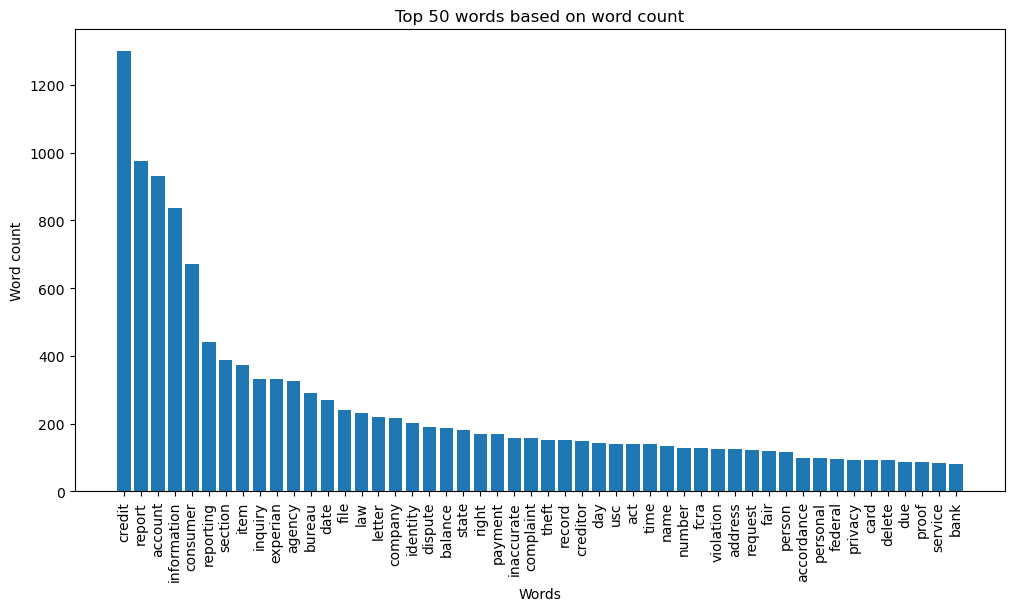

Top 50 words based on word count and their frequency:
{'credit': 1.9446107784431137, 'report': 1.4610778443113772, 'account': 1.3922155688622755, 'information': 1.251497005988024, 'consumer': 1.0059880239520957, 'reporting': 0.6601796407185628, 'section': 0.5808383233532934, 'item': 0.5583832335329342, 'inquiry': 0.49850299401197606, 'experian': 0.49700598802395207, 'agency': 0.4880239520958084, 'bureau': 0.4356287425149701, 'date': 0.4041916167664671, 'file': 0.35778443113772457, 'law': 0.3473053892215569, 'letter': 0.3278443113772455, 'company': 0.3263473053892216, 'identity': 0.30389221556886226, 'dispute': 0.2844311377245509, 'balance': 0.27994011976047906, 'state': 0.2694610778443114, 'right': 0.25449101796407186, 'payment': 0.25149700598802394, 'inaccurate': 0.23652694610778444, 'complaint': 0.23652694610778444, 'theft': 0.22904191616766467, 'record': 0.2275449101796407, 'creditor': 0.2245508982035928, 'day': 0.2125748502994012, 'usc': 0.20958083832335328, 'act': 0.20808383233532

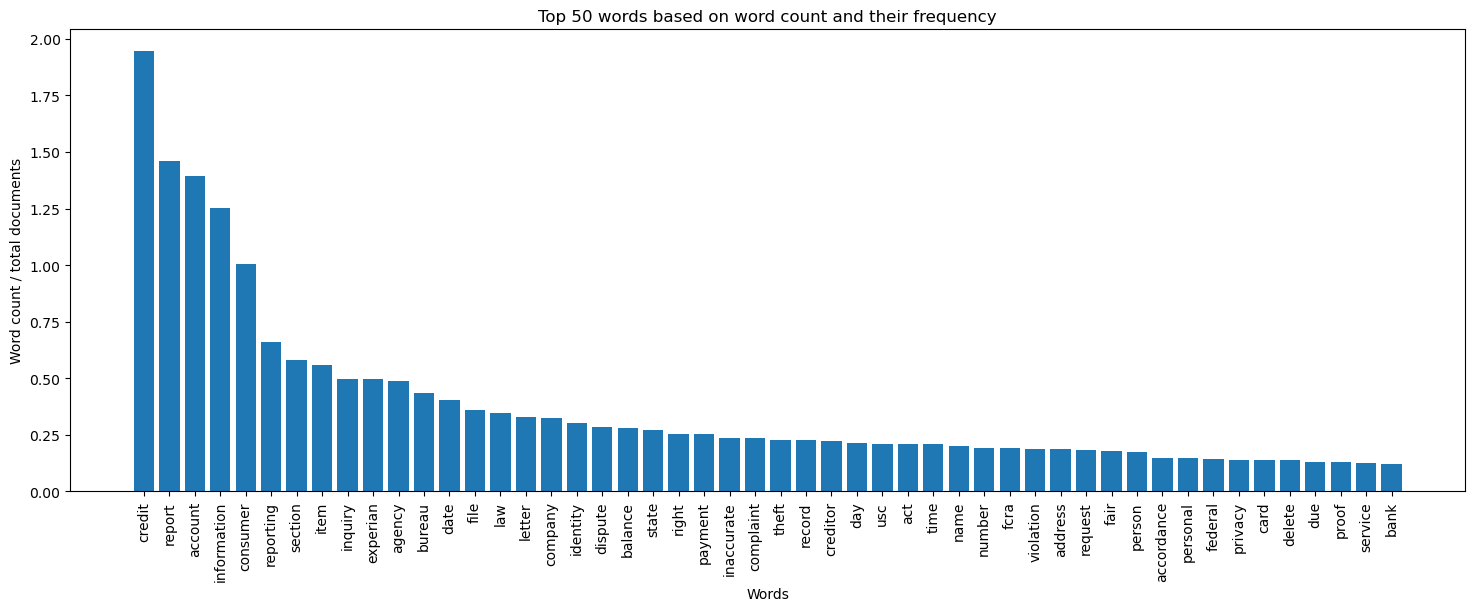

In [10]:
corpus_Top50 = df['bigrams'].tolist()

list_of_lists = [word for sublist in corpus_Top50 for word in sublist]

word_freq = FreqDist(list_of_lists)
top_50_words = dict(word_freq.most_common(50))

print("Top 50 most common words:")
print(word_freq.most_common(50))

plt.figure(figsize=(12,6))
plt.bar(top_50_words.keys(), top_50_words.values())
plt.xticks(rotation='vertical')
plt.title('Top 50 words based on word count')
plt.xlabel('Words')
plt.ylabel('Word count')
plt.show()

no_documents = len(df)

word_freq_share = {word: freq / no_documents for word, freq in top_50_words.items()}
print("Top 50 words based on word count and their frequency:")
print(word_freq_share)

plt.figure(figsize=(18,6))
plt.bar(list(word_freq_share.keys())[:50], list(word_freq_share.values())[:50])
plt.xticks(rotation='vertical')
plt.title('Top 50 words based on word count and their frequency')
plt.xlabel('Words')
plt.ylabel('Word count / total documents')
plt.show()

In [11]:
frequency_threshold = 0.5

tokenized_data = df['bigrams']

list_tokenized_data = df['bigrams'].tolist()
list_of_lists_full = [word for sublist in list_tokenized_data for word in sublist]

word_freq_full = FreqDist(list_of_lists_full)

words_full = dict(word_freq_full)

no_documents_full = len(df)

word_freq_share_full = {word: freq / no_documents_full for word, freq in words_full.items()}

filtered_data = [[word for word in doc if word_freq_share_full[word] <= frequency_threshold] for doc in tokenized_data]

# (4) Vectorization

## (4.1) BoW

In [12]:
corpus = filtered_data
dictionary = corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below=10, no_above=0.95)

bow = [dictionary.doc2bow(text) for text in corpus] 

id_words_bow = [[(dictionary[id], count) for id, count in line] for line in bow]

print(id_words_bow[:5])


[[('error', 1), ('fraud', 1), ('inaccurate', 1), ('personal', 1), ('several', 1)], [('inaccurate', 1), ('accordance', 1), ('accuracy', 2), ('agency', 4), ('appropriate', 1), ('case', 1), ('charge', 1), ('complaint', 3), ('completeness', 1), ('conduct', 1), ('creditor', 2), ('current', 1), ('date', 1), ('delete', 1), ('determine', 1), ('disclosure', 2), ('dispute', 1), ('end', 1), ('experian', 2), ('federal', 1), ('file', 4), ('filing', 1), ('free', 1), ('identification', 1), ('identity', 1), ('law', 2), ('letter', 1), ('multiple', 1), ('notifies', 1), ('number', 3), ('paragraph', 1), ('party', 1), ('period', 1), ('procedure', 1), ('proof', 1), ('reasonable', 1), ('recipient', 1), ('record', 1), ('reinvestigation', 1), ('reinvestigations', 1), ('request', 3), ('requester', 1), ('security', 1), ('similar', 1), ('social', 1), ('source', 1), ('status', 1), ('subject', 1), ('third', 1), ('violation', 1)], [('error', 1), ('personal', 1), ('complaint', 1), ('number', 1), ('security', 1), ('so

## (4.2) TF-IDF 

In [13]:
tfidf_model = TfidfModel(dictionary=dictionary, smartirs='ntc')
tfidf = [tfidf_model[dictionary.doc2bow(text)] for text in corpus]

id_words_tfidf = [[(dictionary[id], np.around(freq,decimals=2)) for id, freq in line] for line in tfidf_model[bow]]

print(id_words_tfidf[:5])

[[('error', 0.54), ('fraud', 0.49), ('inaccurate', 0.31), ('personal', 0.39), ('several', 0.47)], [('inaccurate', 0.06), ('accordance', 0.08), ('accuracy', 0.2), ('agency', 0.21), ('appropriate', 0.12), ('case', 0.12), ('charge', 0.12), ('complaint', 0.2), ('completeness', 0.14), ('conduct', 0.13), ('creditor', 0.16), ('current', 0.12), ('date', 0.07), ('delete', 0.09), ('determine', 0.13), ('disclosure', 0.31), ('dispute', 0.06), ('end', 0.11), ('experian', 0.11), ('federal', 0.09), ('file', 0.26), ('filing', 0.13), ('free', 0.15), ('identification', 0.12), ('identity', 0.07), ('law', 0.12), ('letter', 0.06), ('multiple', 0.11), ('notifies', 0.14), ('number', 0.25), ('paragraph', 0.13), ('party', 0.09), ('period', 0.12), ('procedure', 0.13), ('proof', 0.09), ('reasonable', 0.11), ('recipient', 0.16), ('record', 0.08), ('reinvestigation', 0.13), ('reinvestigations', 0.15), ('request', 0.25), ('requester', 0.16), ('security', 0.12), ('similar', 0.15), ('social', 0.12), ('source', 0.14),

# (5) Topic Modeling

## (5.1) Latent Semantic Analysis (LSA) / Latent Semantic Indexing (LSI) with BoW

Coherence score with 2 clusters: 0.40240793268443986
Coherence score with 3 clusters: 0.4690749690432925
Coherence score with 4 clusters: 0.505341585703652
Coherence score with 5 clusters: 0.5078619766003
Coherence score with 6 clusters: 0.5076037179355705
Coherence score with 7 clusters: 0.5414964886019348
Coherence score with 8 clusters: 0.49957552070640054
Coherence score with 9 clusters: 0.5049388024005279
Coherence score with 10 clusters: 0.49616556705230874
Coherence score with 11 clusters: 0.4609214831965163
Coherence score with 12 clusters: 0.45497492850280025
Coherence score with 13 clusters: 0.44762802452550476
Coherence score with 14 clusters: 0.4589800869300357
Coherence score with 15 clusters: 0.4494014066575676
Coherence score with 16 clusters: 0.4151298647208511
Coherence score with 17 clusters: 0.4726095682056258
Coherence score with 18 clusters: 0.4386306556777899
Coherence score with 19 clusters: 0.43640392109936765
Coherence score with 20 clusters: 0.4203879854004249

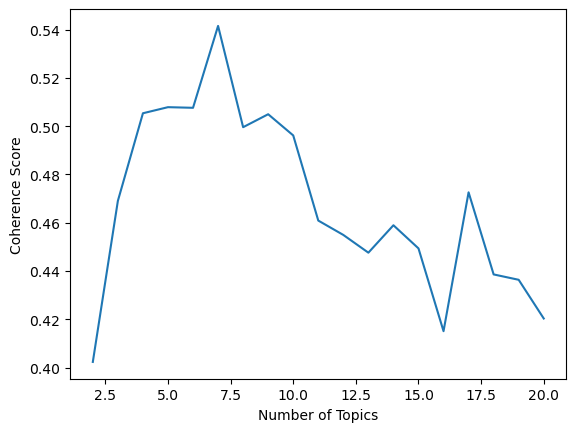

7


In [14]:
df['Assigned_topic_lsi_bow'] = None
df['Topic_score_lsi_bow'] = None

topics = []
score=[]

for i in range(2,21):
    lsi = LsiModel(bow, num_topics = i, id2word = dictionary, power_iters=10)
    coherence_model = CoherenceModel(model=lsi, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))
    
    topics.append(i)
    score.append(coherence_model.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict = dict(zip(topics, score))
max_dict = max(zip(topic_score_dict.values(),topic_score_dict.keys()))[1]
print(max_dict)

In [15]:
lsi_bow = LsiModel(bow, num_topics=max_dict, id2word=dictionary,power_iters=5)

for topic_num, words in lsi_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.893*"inquiry" + 0.440*"date" + 0.030*"unauthorized" + 0.029*"consent" + 0.028*"bureau" + 0.025*"experian" + 0.021*"letter" + 0.018*"number" + 0.018*"delete" + 0.017*"investigation".
Words in 1: 0.326*"experian" + 0.266*"agency" + 0.262*"law" + 0.258*"file" + 0.208*"bureau" + 0.182*"identity" + 0.174*"dispute" + 0.169*"state" + 0.145*"record" + 0.144*"request".
Words in 2: -0.338*"experian" + 0.289*"identity" + -0.264*"last" + 0.217*"agency" + 0.217*"theft" + -0.204*"activity" + -0.195*"different" + -0.192*"request" + 0.179*"record" + -0.173*"delete".
Words in 3: 0.300*"experian" + -0.281*"date" + -0.235*"last" + -0.211*"term" + -0.197*"balance" + 0.196*"right" + -0.185*"identity" + -0.183*"different" + 0.182*"usc" + 0.180*"agency".
Words in 4: 0.480*"experian" + -0.305*"agency" + -0.284*"payment" + -0.226*"usc" + 0.219*"law" + -0.207*"person" + -0.204*"state" + 0.160*"dispute" + -0.155*"privacy" + -0.149*"furnish".
Words in 5: 0.367*"agency" + -0.284*"company" + -0.266*"p

## (5.2) Latent Semantic Analysis (LSA) / Latent Semantic Indexing (LSI) with Tf-Idf

Coherence score with 2 clusters: 0.4103723035180551
Coherence score with 3 clusters: 0.4928550065665363
Coherence score with 4 clusters: 0.548982323182803
Coherence score with 5 clusters: 0.4407612907451527
Coherence score with 6 clusters: 0.42891052609760044
Coherence score with 7 clusters: 0.4246668795408497
Coherence score with 8 clusters: 0.3403122089482885
Coherence score with 9 clusters: 0.3632190780615509
Coherence score with 10 clusters: 0.413131394937947
Coherence score with 11 clusters: 0.4012919970956292
Coherence score with 12 clusters: 0.41471423992229384
Coherence score with 13 clusters: 0.42030282932923085
Coherence score with 14 clusters: 0.38623113356730043
Coherence score with 15 clusters: 0.37164060991236936
Coherence score with 16 clusters: 0.35047799912624145
Coherence score with 17 clusters: 0.38731269980993044
Coherence score with 18 clusters: 0.35474995225138956
Coherence score with 19 clusters: 0.37452551102263487
Coherence score with 20 clusters: 0.34242734448

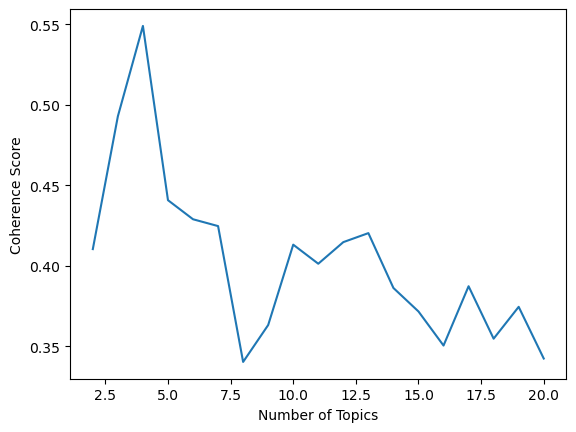

4
Words in 0: 0.247*"agency" + 0.214*"state" + 0.201*"right" + 0.192*"privacy" + 0.179*"furnish" + 0.178*"act" + 0.177*"instruction" + 0.173*"usc" + 0.171*"fair" + 0.171*"accordance".
Words in 1: 0.286*"privacy" + 0.281*"instruction" + 0.279*"furnish" + 0.242*"state" + 0.227*"right" + 0.218*"accordance" + 0.211*"fair" + -0.205*"inquiry" + 0.204*"act" + 0.161*"agency".
Words in 2: -0.757*"inquiry" + -0.254*"hard" + -0.223*"unauthorized" + -0.182*"company" + 0.143*"balance" + 0.140*"identity" + 0.131*"theft" + 0.120*"law" + 0.107*"file" + 0.086*"record".
Words in 3: 0.306*"letter" + 0.287*"mailed" + 0.287*"involved" + 0.284*"gotten" + 0.276*"name" + 0.272*"review" + 0.255*"sure" + 0.250*"third" + 0.242*"response" + 0.197*"party".


In [17]:
topics_LSI_tfidf = []
score_LSI_tfidf=[]

for i in range(2,21):
    lsi_tfidf = LsiModel(tfidf, num_topics = i, id2word = dictionary, power_iters = 10)
    coherence_model_tfidf = CoherenceModel(model=lsi_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score_tfidf = coherence_model_tfidf.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score_tfidf))
    
    topics_LSI_tfidf.append(i)
    score_LSI_tfidf.append(coherence_model_tfidf.get_coherence())
    
_=plt.plot(topics_LSI_tfidf, score_LSI_tfidf)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict_tfidf = dict(zip(topics_LSI_tfidf, score_LSI_tfidf))
max_dict_tfidf = max(zip(topic_score_dict_tfidf.values(),topic_score_dict_tfidf.keys()))[1]
print(max_dict_tfidf)

lsi_tfidf = LsiModel(tfidf, num_topics=max_dict_tfidf, id2word=dictionary,power_iters=10)

for topic_num, words in lsi_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

In [18]:
lsi_tfidf = LsiModel(tfidf, num_topics=max_dict_tfidf, id2word=dictionary,power_iters=10)

for topic_num, words in lsi_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.247*"agency" + 0.214*"state" + 0.201*"right" + 0.192*"privacy" + 0.179*"furnish" + 0.178*"act" + 0.177*"instruction" + 0.173*"usc" + 0.171*"fair" + 0.171*"accordance".
Words in 1: -0.286*"privacy" + -0.281*"instruction" + -0.279*"furnish" + -0.242*"state" + -0.227*"right" + -0.218*"accordance" + -0.211*"fair" + 0.205*"inquiry" + -0.204*"act" + -0.161*"agency".
Words in 2: 0.757*"inquiry" + 0.254*"hard" + 0.223*"unauthorized" + 0.182*"company" + -0.143*"balance" + -0.140*"identity" + -0.131*"theft" + -0.120*"law" + -0.107*"file" + -0.086*"record".
Words in 3: 0.306*"letter" + 0.287*"mailed" + 0.287*"involved" + 0.284*"gotten" + 0.276*"name" + 0.272*"review" + 0.255*"sure" + 0.250*"third" + 0.242*"response" + 0.197*"party".


## (5.3) Latent Dirichlet Allocation (LDA) with BoW

Coherence score with 2 clusters: 0.41589630628164775
Coherence score with 3 clusters: 0.3875543341081494
Coherence score with 4 clusters: 0.38116709799512216
Coherence score with 5 clusters: 0.4020778346069472
Coherence score with 6 clusters: 0.4088045503761828
Coherence score with 7 clusters: 0.3971626560424991
Coherence score with 8 clusters: 0.41621759181808793
Coherence score with 9 clusters: 0.4437842424756193
Coherence score with 10 clusters: 0.38360610560951247
Coherence score with 11 clusters: 0.36926204390908945
Coherence score with 12 clusters: 0.39817271121987385
Coherence score with 13 clusters: 0.39530837533512647
Coherence score with 14 clusters: 0.43070668964110265
Coherence score with 15 clusters: 0.3932421386060776
Coherence score with 16 clusters: 0.38460367492865327
Coherence score with 17 clusters: 0.3926166920519864
Coherence score with 18 clusters: 0.4011794283640343
Coherence score with 19 clusters: 0.40263506275485256
Coherence score with 20 clusters: 0.36459255

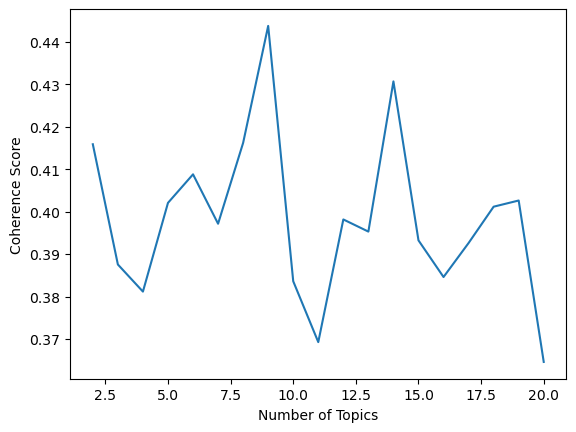

9


In [19]:
topics_LDA_bow = []
score_LDA_bow=[]

for i in range(2,21):
    lda_bow = LdaModel(corpus=bow,id2word=dictionary, num_topics = i, iterations = 100)
    coherence_model_lda_bow = CoherenceModel(model=lda_bow, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score_lda_bow = coherence_model_lda_bow.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score_lda_bow))
    
    topics_LDA_bow.append(i)
    score_LDA_bow.append(coherence_model_lda_bow.get_coherence())
    
_=plt.plot(topics_LDA_bow, score_LDA_bow)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict_lda_bow = dict(zip(topics_LDA_bow, score_LDA_bow))
max_dict_lda_bow = max(zip(topic_score_dict_lda_bow.values(),topic_score_dict_lda_bow.keys()))[1]
print(max_dict_lda_bow)

In [20]:
lda_bow = LdaModel(corpus=bow,id2word=dictionary, num_topics = max_dict_lda_bow, iterations = 100)

for topic_num, words in lda_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.033*"file" + 0.031*"law" + 0.029*"record" + 0.025*"bureau" + 0.024*"belong" + 0.022*"research" + 0.018*"identity" + 0.014*"legal" + 0.013*"inaccurate" + 0.013*"action".
Words in 1: 0.040*"company" + 0.032*"inquiry" + 0.029*"balance" + 0.024*"experian" + 0.023*"letter" + 0.020*"law" + 0.019*"bureau" + 0.017*"time" + 0.016*"violation" + 0.015*"agency".
Words in 2: 0.159*"inquiry" + 0.073*"date" + 0.024*"unauthorized" + 0.024*"record" + 0.021*"creditor" + 0.021*"consent" + 0.021*"agency" + 0.019*"right" + 0.017*"person" + 0.014*"experian".
Words in 3: 0.039*"letter" + 0.036*"agency" + 0.033*"bureau" + 0.025*"experian" + 0.022*"file" + 0.022*"date" + 0.020*"law" + 0.019*"number" + 0.017*"dispute" + 0.016*"complaint".
Words in 4: 0.042*"bureau" + 0.035*"identity" + 0.029*"theft" + 0.019*"experian" + 0.018*"company" + 0.017*"letter" + 0.017*"complaint" + 0.016*"address" + 0.015*"state" + 0.014*"debt".
Words in 5: 0.038*"payment" + 0.029*"balance" + 0.024*"identity" + 0.021*"the

## (5.4) Latent Dirichlet Allocation (LDA) with Tf-Idf

Coherence score with 2 clusters: 0.3726305692413
Coherence score with 3 clusters: 0.36875621739580816
Coherence score with 4 clusters: 0.36893475844449297
Coherence score with 5 clusters: 0.33603844491747664
Coherence score with 6 clusters: 0.3496414077688175
Coherence score with 7 clusters: 0.2915931952028185
Coherence score with 8 clusters: 0.33273793481551933
Coherence score with 9 clusters: 0.3640583215406526
Coherence score with 10 clusters: 0.3367489835589563
Coherence score with 11 clusters: 0.29961417562603376
Coherence score with 12 clusters: 0.3227114940715897
Coherence score with 13 clusters: 0.314992357830627
Coherence score with 14 clusters: 0.30509429703419333
Coherence score with 15 clusters: 0.3346159596620705
Coherence score with 16 clusters: 0.30986394547586504
Coherence score with 17 clusters: 0.3028341346086888
Coherence score with 18 clusters: 0.3235647789456181
Coherence score with 19 clusters: 0.3217908849227311
Coherence score with 20 clusters: 0.328815372369506

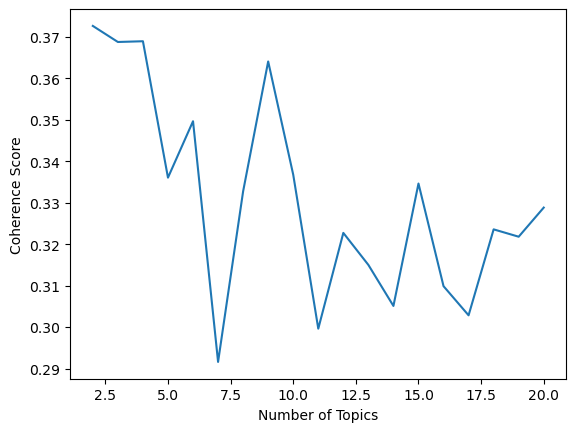

2


In [21]:
topics_LDA_tfidf = []
score_LDA_tfidf=[]

for i in range(2,21):
    lda_tfidf = LdaModel(corpus=tfidf,id2word=dictionary, num_topics = i, iterations = 100)
    coherence_model_lda_tfidf = CoherenceModel(model=lda_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
    coherence_score_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score_lda_tfidf))
    
    topics_LDA_tfidf.append(i)
    score_LDA_tfidf.append(coherence_model_lda_tfidf.get_coherence())
    
_=plt.plot(topics_LDA_tfidf, score_LDA_tfidf)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

topic_score_dict_lda_tfidf = dict(zip(topics_LDA_tfidf, score_LDA_tfidf))
max_dict_lda_tfidf = max(zip(topic_score_dict_lda_tfidf.values(),topic_score_dict_lda_tfidf.keys()))[1]
print(max_dict_lda_tfidf)

In [22]:
lda_tfidf = LdaModel(corpus=tfidf,id2word=dictionary, num_topics = max_dict_lda_tfidf, iterations = 100)

for topic_num, words in lda_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.013*"experian" + 0.013*"agency" + 0.012*"letter" + 0.012*"company" + 0.011*"balance" + 0.010*"inquiry" + 0.010*"inaccurate" + 0.009*"name" + 0.009*"bureau" + 0.009*"address".
Words in 1: 0.018*"inquiry" + 0.011*"agency" + 0.011*"bureau" + 0.011*"right" + 0.011*"usc" + 0.011*"experian" + 0.010*"inaccurate" + 0.010*"company" + 0.010*"state" + 0.010*"file".


## (5.5) Hierarchical Dirichlet Process (HDP) with BoW

In [23]:
hdp_bow = HdpModel(corpus=bow,id2word=dictionary)

for topic_num, words in hdp_bow.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))
    
no_topics = topic_num

Words in 0: 0.021*department + 0.020*free + 0.016*gotten + 0.014*send + 0.013*amount + 0.012*confidentiality + 0.012*bill + 0.011*service + 0.011*late + 0.010*file.
Words in 1: 0.023*way + 0.016*best + 0.014*document + 0.013*plan + 0.013*furnishers + 0.013*contract + 0.012*incomplete + 0.011*removal + 0.011*identification + 0.011*doubt.
Words in 2: 0.026*address + 0.017*home + 0.016*fcra + 0.015*see + 0.014*profile + 0.013*dispute + 0.012*help + 0.012*correct + 0.012*accordance + 0.011*reinvestigation.
Words in 3: 0.017*gotten + 0.017*fraud + 0.016*true + 0.015*investigation + 0.014*attorney + 0.011*charge + 0.011*sent + 0.010*claim + 0.010*unable + 0.010*negative.
Words in 4: 0.015*receipt + 0.014*month + 0.014*authorization + 0.013*appropriate + 0.012*experian + 0.011*usc + 0.011*rule + 0.011*previous + 0.011*transaction + 0.011*cause.
Words in 5: 0.016*major + 0.016*instruction + 0.015*completeness + 0.015*right + 0.014*source + 0.014*request + 0.014*seek + 0.014*responsibility + 0.

In [24]:
coherence_model_hdp_bow = CoherenceModel(model=hdp_bow, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
coherence_score_hdp_bow = coherence_model_hdp_bow.get_coherence()
print('Coherence score with {} clusters: {}'.format(no_topics, coherence_score_hdp_bow))

Coherence score with 19 clusters: 0.421038029509843


## (5.6) Hierarchical Dirichlet Process (HDP) with Tf-Idf

In [25]:
hdp_tfidf = HdpModel(corpus=tfidf,id2word=dictionary)

for topic_num, words in hdp_tfidf.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.020*request + 0.020*attached + 0.019*lender + 0.015*aware + 0.015*hard + 0.014*incomplete + 0.013*correct + 0.013*profile + 0.011*permissible + 0.011*criminal.
Words in 1: 0.017*usc + 0.017*doubt + 0.015*result + 0.014*frame + 0.014*record + 0.013*email + 0.012*delete + 0.012*criminal + 0.011*copy + 0.011*want.
Words in 2: 0.022*agency + 0.021*subject + 0.016*authority + 0.014*email + 0.012*validate + 0.012*term + 0.012*mortgage + 0.011*third + 0.011*enforcement + 0.011*major.
Words in 3: 0.019*code + 0.017*check + 0.014*adverse + 0.014*possibility + 0.014*valid + 0.013*form + 0.013*get + 0.013*involved + 0.012*home + 0.012*ftc.
Words in 4: 0.018*criminal + 0.015*crime + 0.013*anything + 0.013*authorization + 0.012*line + 0.012*thing + 0.012*fcra + 0.012*language + 0.010*security + 0.010*concern.
Words in 5: 0.017*official + 0.014*high + 0.013*matter + 0.013*service + 0.012*payment + 0.012*incorrect + 0.012*document + 0.012*late + 0.011*balance + 0.011*ftc.
Words in 6: 0.

In [26]:
coherence_model_hdp_tfidf = CoherenceModel(model=hdp_tfidf, texts=filtered_data, dictionary=dictionary, coherence ='c_v')
coherence_score_hdp_tfidf = coherence_model_hdp_tfidf.get_coherence()
print('Coherence score with {} clusters: {}'.format(no_topics, coherence_score_hdp_tfidf))

Coherence score with 19 clusters: 0.41159256807024114
